# Knowledge-guided Open Attribute Value Extraction with Reinforcement Learning



#### Members' Names: James Jewitt Sean Berry

####  Emails: jjewitt@ryerson.ca sean.berry@ryerson.ca

# Introduction:

#### Problem Description:

 

#### Context of the Problem:

With the Vast amount of new and novel information generated every day, it becomes difficult to maintain large databases with complete accuracy. Open Attribute Extraction is a potential method for the non-human collection and generation of this data. This model could significantly reduce the time for collecting data and reduce the time that people have to label and Fix this data manually. 

#### Limitation About other Approaches:

Other models have the issue of requiring significant Preexisting knowledge about the topics within the questions. They can also have problems selecting the most correct answer for the question due to noisy data. 

#### Solution:

Here we propose to utilize and tune A Bert Answer Extraction model models and use Deep-Q learning guided by a knowledge graph to select the best possible answer to extract new information and data. 

# Background




| Reference |Explanation |  Dataset/Input |Weakness
| --- | --- | --- | --- |
| Barzilay et al. [1] | They Utilized a Deep Q learning with a maximum entropy classifier to Extract the best answers for their Datasets | Gun Violence Archive, FoodSheild EMA Database | Requires a lot of context information about the specific answers being extracted | 
| Seo et al. [2] | Uses Bidirectional flow and a multi stage hierarchical learning process to obtain query aware  information for learning question answers | CNN and Daily Mail datasets | Generally outperformed by Bert Due to only using attention from words in the sequence|
| Karamanolakis et al [3] | Utilizes a taxonomy aware knowledge  extraction that utilizes self attention to extract attributes from e commerce sites | Data scraped from online ecomerce sites | Has problems with dealing with noisy  data | 
| Song et al. [4] | Uses Deep Q Learning along with a Knowledge graph to extract awnsers from machine comprehention models | CNDBpedia data,We-bQA  and CIPS-SOGOU factoidquestion-answering subtask dataset | |  



# Methodology

### Problem

This paper aims to predict a value from a triplet of information in the format < entity, attribute, value > where we are looking to predict the value. For example, for the triplet < GTX 1080, core code, ?> we would be trying to find the best answer to what is the core code of a GTX 1080.  

### Data Encoding
### Data 
The data used in this paper has been extracted from the search engine Baidu by taking the entity and attribute and formulating them into a question. The first ten results are taken to find a suitable answer from. 


### Bert 
For Answer Extraction, Bert is utilized. For training the Bert model, CIPS-SOGOU factoidquestion-answering subtask dataset is trained for extracting the desired text. The data must be converted into a squad-like format to which the model can be fine-tuned for Extraction. 
A Bert model with 12 Encoders with 12 Bidirectional self-attention heads are used to fine-tune for question answering from the dataset. The answers are embedded into an embedded state vector through similarity metrics and confidence scores which are fed into a DQN learner to select the best answer. 


 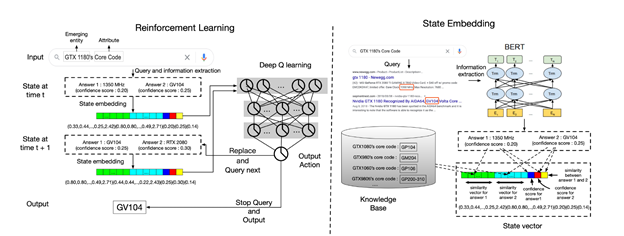
### DQN Answer selection 

From the BERT answer extraction, a Reinforcement learning model is formalized as an MDP to sequentially go over and compare answers to select the best one for the question. It compares two articles and attempts to determine between the two. The model has 3 Actions, retain, replace, or Stop. Stopping before comparing all articles is important as an option as it can help noisy filter data that could be introduced with extra articles. The state variables are derived from the Levenstein similarity metrics below: 

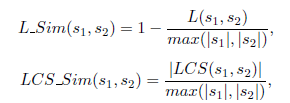
 
This is the section the knowledge graph is leveraged to give the learner background knowledge about the answer. The Bert answers are compared to how similar it is to the KG's. Deriving seven features from these similarity metrics based on masking. F1: L Sim between s1 and s2; f2: LCS Sim between s1 and s2; f3: L Sim between s1 and s2 with numbers removed from s1, s2; f4: LCS Sim between s1 and s2 with numbers removed from s1, s2; f5: L Sim between s1 and s2 with s1, s2 wildcard masked2; f6: LCS Sim between s1 and s2 with s1, s2 wildcard masked; f7: The difference in the length of s1 and s2 in characters. These are further expanding into 28 state variables based on the reference values and answers from the two compared articles. The reward is given to the system when the stop action is selected. 

 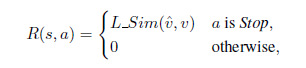


# Implementation

The General Process for our implementation is



*   Data Preprocessing: required to format the website data into a Squad-Like Format
*   Bert Training: running the test and train data through Bert
*   Deep Q learning Encoding: format the output for our Deep Q learning
*   baseline testing - Performing baseline performance tests through simple selection measures: Random choice, First Choice, Majority Aggregation, Confidence Aggregation
*   Deep Q learning Model Training and Evaluation 
*   Running the Training with portions of the KG missing




## Data Preparation   

In [ ]:
%%capture
print('NOTE: Intentionally crashing session to use the newly installed library.\n')
!pip uninstall -y pyarrow
!pip install ray[debug]==0.7.5
# A hack to force the runtime to restart, needed to include the above dependencies.
import os
os._exit(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 1.x
import os
import sys
os.chdir("drive/MyDrive/knowledge")

TensorFlow 1.x selected.


In [ ]:
%%capture
!pip install python-Levenshtein
!pip install redis
!pip install -U ray
!pip install ray[debug]==0.7.5
!pip install ray[rllib]  # also recommended: ray[debug]
!pip uninstall -y pyarrow
!pip install unicodedata2


In [ ]:
import tensorflow as tf
import pickle
import random
import pandas as pd 
import numpy as np
import json
import time
import sys
sys.path.append('/src/bert')
sys.path.append('/src/helper')
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import unicodedata
from functools import reduce
#### Import ray related package
import ray
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.fcnet_v2 import FullyConnectedNetwork

from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.rllib.models.tf.misc import normc_initializer
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.agents.dqn.distributional_q_model import DistributionalQModel
from ray.rllib.models.tf.visionnet_v2 import VisionNetwork as MyVisionNetwork
from ray.tune.logger import pretty_print
from ray.rllib.utils import try_import_tf
from ray.tune import grid_search
from ray.rllib.models import ModelCatalog
from ray.tune import Trainable
from ray.tune.logger import pretty_print
from ray.tune import run as run_tune
from ray.tune.registry import register_env
import gym
from gym import spaces
from gym.spaces import Discrete, Box
from ray import tune
from ray.rllib.agents.dqn.dqn import DQNTrainer, DEFAULT_CONFIG
### import self-defined function
from helper import *
# import similarity_metrics
from src.helper.utility_function import *
### import Environment
from src.helper.Environment import KGRLEnv
### Import Customized DQN
# from PolicyDQN import *
tf.__version__
from src.helper.PolicyDQN import *
import os
import json
import pickle

In [ ]:
########################################################
## convert the distance data into squad-like dataset ###
########################################################


def convert_distance_datasquad(file_name_input = 'sougou.json', file_name_output = None):
  
  data = {}
  data['data'] = []
  f = open(file_name_input, "r")
  lines = f.readlines()
  for i in range(len(lines)):
    line = lines[i]
    oneline = json.loads(line)
    answer = oneline['answer']
    passages = oneline['passages']
    question = oneline['question']
    for j in range(len(passages)):
      start_id = passages[j]['passage_text'].find(answer)
      if start_id == -1: continue
      entry = {}
      entry["paragraphs"] = [{
        'context' : passages[j]['passage_text'],
        'qas' : [{'question' : question,
                  'id' : "Trainbaidu_" + str(i) + "_context_" + str(j),
                  'answers' : [{'answer_start': start_id, 
                                'text': answer}]  }]
      }]
      data['data'].append(entry)
      break 

  with open(file_name_output, 'w') as outfile:
      json.dump(data, outfile)
  return data

#####################################
## covert our data into squad-like ##
#####################################


def convert_squad(test_data, file_name = 'test_baidu_good.json'):
  

  data = {}
  data['data'] = []
  for i in range(len(test_data)):
    answer = test_data[i]['o']
    passages = test_data[i]['corpus']
    question = test_data[i]['s'] + "的" + test_data[i]['p'] + "是什么？"
    for j in range(len(passages)):
      start_id = None
      entry = {}
      entry["paragraphs"] = [{
        'context' : passages[j],
        'qas' : [{'question' : question,
                  'id' : "Trainbaidu_" + str(i) + "_context_" + str(j),
                  'answers' : [{'answer_start': start_id, 
                                'text': answer}]  }]
      }]
      data['data'].append(entry)
      #print(i)

        #break ## 每个问题有一个文本就好了。 (不然太太太多了？)


  with open(file_name, 'w') as outfile:
      json.dump(data, outfile)

distance_data_dir = "./data/distance_data/"
data = convert_distance_datasquad(file_name_input = distance_data_dir + 'sougou.json', file_name_output = distance_data_dir + 'sougou_squad.json')


train_data = pickle.load(open("./data/preprocessed_data/train_data.pkl", "rb" ))
test_data = pickle.load(open("./data/preprocessed_data/test_data.pkl", "rb" ))
store_dir = "./data/preprocessed_data/"
convert_squad(test_data, file_name = store_dir + 'test_data_squad.json')
convert_squad(train_data, file_name = store_dir + 'train_data_squad.json')
# /content/drive/MyDrive/data/preprocessed_data


## Running Bert Model

In [ ]:

## ref https://github.com/google-research/bert
#########################################################
## use bert to fine tune and predict on our test data  ##
#########################################################
%%capture
!python ./src/bert/run_squad.py  \
    --vocab_file=./src/bert/chinese_L-12_H-768_A-12/vocab.txt \
    --bert_config_file=./src/bert/chinese_L-12_H-768_A-12/bert_config.json \
    --init_checkpoint=./src/bert/chinese_L-12_H-768_A-12/bert_model.ckpt \
    --do_train=True \
    --train_file=./data/distance_data/sougou_squad.json \
    --do_predict=True \
    --predict_file=./data/preprocessed_data/test_data_squad.json \
    --train_batch_size=12 --num_train_epochs=2.0 \
    --max_seq_length=384 \
    --doc_stride=128 \
    --learning_rate=3e-5 \
    --save_checkpoints_steps=1000 \
    --output_dir=./data/bert_output/distant_supervision_test \
    --do_lower_case=True \
    --use_tpu=False \
    --tpu_name=${TPU_NAME}
    


In [ ]:
#############################################################
## use bert to fine tune and predict on our training data  ##
#############################################################
%%capture
!python ./src/bert/run_squad.py  \
    --vocab_file=./src/bert/chinese_L-12_H-768_A-12/vocab.txt \
    --bert_config_file=./src/bert/chinese_L-12_H-768_A-12/bert_config.json \
    --init_checkpoint=./src/bert/chinese_L-12_H-768_A-12/bert_model.ckpt \
    --do_train=True \
    --train_file=./data/distance_data/sougou_squad.json \
    --do_predict=True \
    --predict_file=./data/preprocessed_data/train_data_squad.json \
    --train_batch_size=12 --num_train_epochs=2 \
    --max_seq_length=384 \
    --doc_stride=128 \
    --learning_rate=3e-5 \
    --save_checkpoints_steps=1000 \
    --output_dir=./data/bert_output/distant_supervision_full_train \
    --do_lower_case=True \
    --use_tpu=False

## Process data For Deep Q learning Model

In [ ]:

def pickle_answer(input_data, pred_file = "dev_predictions_test.json",\
                  pred_file_nbest = "dev_nbest_predictions_test.json",\
                  file_name_output = "pred_train_bert.pkl", saving_path = "./preprocessed_data/"):
  
  
  with open(pred_file, "r") as read_file:
      dev_data = json.load(read_file)

  with open(pred_file_nbest, "r") as read_file:
      dev_data_nbest = json.load(read_file)

  pred_output = {}
  for i in range(len(input_data)):
    tmp = []
    for j in range(len(input_data[i]['corpus'])):
      dev_id = 'Trainbaidu_%d_context_%d' %(i, j)
      try:
        tmp.append( [ [dev_data[dev_id]], [dev_data_nbest[dev_id][0]['probability']] ])
      except:
        tmp.append( [ ["ERROR"], [0] ])
    pred_output[input_data[i]['id']] = tmp
  with open(saving_path + file_name_output, 'wb') as f:
    pickle.dump(pred_output, f)
  
saving_path = "./data/preprocessed_data/"
bert_output_path = "./data/bert_output/"

train_data = pickle.load(open("./data/preprocessed_data/train_data.pkl", "rb" ))
test_data = pickle.load(open("./data/preprocessed_data/test_data.pkl", "rb" ))

# save test data
pickle_answer(input_data = test_data, pred_file = bert_output_path + "distant_supervision_test/predictions.json",\
              pred_file_nbest = bert_output_path + "distant_supervision_test/nbest_predictions.json",\
              file_name_output = "pred_test_bert.pkl", saving_path = saving_path)
# save train data
pickle_answer(input_data = train_data, pred_file = bert_output_path + "distant_supervision_full_train/predictions.json",\
              pred_file_nbest = bert_output_path + "distant_supervision_full_train/nbest_predictions.json",\
              file_name_output = "pred_train_bert.pkl", saving_path = saving_path)


# Read processed data


In [ ]:
method = "bert" ## possible methods: "bert", "bidaf", "qanet"
########################################
## read preprocessed data(train/test) ##
########################################
train_data = pickle.load(open("data/preprocessed_data/train_data.pkl", "rb" ))
test_data = pickle.load(open("data/preprocessed_data/test_data.pkl", "rb" ))
test_data_types = [test_data[i]['type'] for i in range(len(test_data))]

do_bert = False
if method == "bert":
  do_bert = True
#######################################################
### Obtain the pickled predition for train and test ###
#######################################################
saving_path ="data/preprocessed_data/"
train_file = "pred_train_%s.pkl" %method ; test_file = "pred_test_%s.pkl" %method
pred_train = pickle.load(open(saving_path + train_file, "rb" ))
pred_test = pickle.load(open(saving_path + test_file, "rb" ))

# Santity check

In [ ]:
##################
## santity check #
##################
## check the length of pickled answer
for k,v in pred_train.items():
  assert len(v) == 10, "%s does not match" %k

for k,v in pred_test.items():
  assert len(v) == 10, "%s does not match" %k

#### check the length of example_similarity_features
ans = '65nm'
reference_values = ['16nm FinFET', '16nm FinFET', '14nm FinFET', '28纳米', '65nm',
        '28纳米', '16nm FinFET']
example_similarity_features = get_sim_features(ans, reference_values, do_bert = do_bert)
len_similarity_features = len(example_similarity_features)
print(len_similarity_features)
print(example_similarity_features)

14
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 6.0, 0.5142857142857143, 0.5142857142857143, 0.2857142857142857, 0.2857142857142857, 0.2571428571428571, 0.3, 3.4285714285714284]


# Baseline Performance

In [ ]:
print("+" * 30 + " For method %s, the scores are " %method + "+" * 30)
avg_score = []
oracle_score = []
max_conf_score = []
majority_vote_score = []
first_score = []

flatten = lambda l: [item for sublist in l for item in sublist]
for i in range(len(test_data)):
  cur = pred_test['Test_'+str(i)]
  candidate_answer = [cur[j][0][0] for j in range(len(cur))]
  confs = [cur[j][1][0] for j in range(len(cur))]
  if do_bert: ## if do bert the object should be preprocessed as original bert paper
    sims = [similarity_metrics.LevenSim(c, token_word(test_data[i]['o']) ) for c in candidate_answer]
  else:
    sims = [similarity_metrics.LevenSim(c, test_data[i]['o']) for c in candidate_answer]
  # majority vote
  c = Counter(candidate_answer)
  ans_majority_vote, _ = c.most_common()[0]
  first_score.append(sims[0])
  avg_score.append(np.mean(sims))
  max_conf_score.append(sims[np.argmax(confs)])
  majority_vote_score.append(similarity_metrics.LevenSim(ans_majority_vote, 
                                                         test_data[i]['o']))
  oracle_score.append(np.max(sims))

test_data_types = [test_data[i]['type'] for i in range(len(test_data))]
GPU_test_index = [i for i in range(len(test_data)) if test_data_types[i] == 'GPUs']
Game_test_index = [i for i in range(len(test_data)) if test_data_types[i] == 'Games']
Movie_test_index = [i for i in range(len(test_data)) if test_data_types[i] == 'Movies']
Phone_test_index = [i for i in range(len(test_data)) if test_data_types[i] == 'phones']

## print the scores 

print("first score is %0.3f (Overall)"%np.mean(np.array(first_score)))
print("avg score is %0.3f (Overall)"%np.mean(np.array(avg_score)))
print("mac conf score is %0.3f (Overall)"%np.mean(np.array(max_conf_score)))
print("majority vote score is %0.3f (Overall)"%np.mean(np.array(majority_vote_score)))
print("oracle score is %0.3f (Overall)"%np.mean(np.array(oracle_score)))

index_to_use = GPU_test_index
print("first score is %0.3f for GPU"%np.mean(np.array(first_score)[index_to_use]))
print("avg score is %0.3f for GPU"%np.mean(np.array(avg_score)[index_to_use]))
print("mac conf score is %0.3f for GPU"%np.mean(np.array(max_conf_score)[index_to_use]))
print("majority vote score is %0.3f for GPU"%np.mean(np.array(majority_vote_score)[index_to_use]))
print("oracle score is %0.3f for GPU"%np.mean(np.array(oracle_score)[index_to_use]))

index_to_use = Game_test_index
print("first score is %0.3f for GAME"%np.mean(np.array(first_score)[index_to_use]))
print("avg score is %0.3f for GAME"%np.mean(np.array(avg_score)[index_to_use]))
print("mac conf score is %0.3f for GAME"%np.mean(np.array(max_conf_score)[index_to_use]))
print("majority vote score is %0.3f for GAME"%np.mean(np.array(majority_vote_score)[index_to_use]))
print("oracle score is %0.3f for GAME"%np.mean(np.array(oracle_score)[index_to_use]))

index_to_use = Movie_test_index
print("first score is %0.3f for MOVIE"%np.mean(np.array(first_score)[index_to_use]))
print("avg score is %0.3f for MOVIE"%np.mean(np.array(avg_score)[index_to_use]))
print("mac conf score is %0.3f for MOVIE"%np.mean(np.array(max_conf_score)[index_to_use]))
print("majority vote score is %0.3f for MOVIE"%np.mean(np.array(majority_vote_score)[index_to_use]))
print("oracle score is %0.3f for MOVIE"%np.mean(np.array(oracle_score)[index_to_use]))

index_to_use = Phone_test_index
print("first score is %0.3f for PHONE"%np.mean(np.array(first_score)[index_to_use]))
print("avg score is %0.3f for PHONE"%np.mean(np.array(avg_score)[index_to_use]))
print("mac conf score is %0.3f for PHONE"%np.mean(np.array(max_conf_score)[index_to_use]))
print("majority vote score is %0.3f for PHONE"%np.mean(np.array(majority_vote_score)[index_to_use]))
print("oracle score is %0.3f for PHONE"%np.mean(np.array(oracle_score)[index_to_use]))

++++++++++++++++++++++++++++++ For method bert, the scores are ++++++++++++++++++++++++++++++
first score is 0.536 (Overall)
avg score is 0.219 (Overall)
mac conf score is 0.443 (Overall)
majority vote score is 0.454 (Overall)
oracle score is 0.734 (Overall)
first score is 0.379 for GPU
avg score is 0.182 for GPU
mac conf score is 0.384 for GPU
majority vote score is 0.446 for GPU
oracle score is 0.617 for GPU
first score is 0.486 for GAME
avg score is 0.151 for GAME
mac conf score is 0.404 for GAME
majority vote score is 0.290 for GAME
oracle score is 0.664 for GAME
first score is 0.621 for MOVIE
avg score is 0.313 for MOVIE
mac conf score is 0.528 for MOVIE
majority vote score is 0.592 for MOVIE
oracle score is 0.875 for MOVIE
first score is 0.657 for PHONE
avg score is 0.228 for PHONE
mac conf score is 0.457 for PHONE
majority vote score is 0.489 for PHONE
oracle score is 0.781 for PHONE


# Train

In [ ]:
seed = 20201015
np.random.seed(seed)
tf.random.set_random_seed(seed)
ray.init(num_gpus=1, log_to_driver=False, local_mode=True, ignore_reinit_error=True)
ModelCatalog.register_custom_model("keras_q_model", DQNModel)
qTrainer = DQNTrainer(env=KGRLEnv, config={# config to pass to env class
    "model": {
        "custom_model": "keras_q_model"
    },
    "seed" : seed,
    "env_config": {"training": True, "idx_to_test":None, "train_data" : train_data,"test_data": test_data,"pred_train":  pred_train, "pred_test" : pred_test, "do_bert" : do_bert},
    "buffer_size":100,
    "lr_schedule": [[0, 0.05], [20, 0.01], [30, 0.005], [50, 0.001]],
    "train_batch_size":100
  })


total_iteration = 20
prev_time = time.time()
for i in range(total_iteration):
    print("iteration {};".format(i), \
          "%d sec/iteration;" % (time.time()- prev_time), \
          "%d min remaining" % ((total_iteration - i)*(time.time()- prev_time)/60))
    prev_time = time.time()
    qTrainer.train()
    
print("Training Done!")

# **Evaluation**

In [ ]:
def evaluation_q(test_data, pred_test, qTrainer):
    rewards = []
    steps = []
    for i in range(len(test_data)):
      env = KGRLEnv({"training": False, "idx_to_test":i, "train_data" : None, "test_data": test_data,"pred_train":  None, "pred_test" : pred_test, "do_bert" : do_bert})
      state = env.state
      done = False
      while not done:
          action = qTrainer.compute_action(state)
          state, reward, done, results = env.step(action)
      rewards.append(reward)
      steps.append(results['steps'])
    return rewards, steps

reward_list, step_list = evaluation_q(test_data, pred_test, qTrainer)
avg_reward = np.mean(reward_list)
avg_steps = np.mean(step_list)

GPU_reward = np.mean(np.array(reward_list)[GPU_test_index])
GPU_steps = np.mean(np.array(step_list)[GPU_test_index])

Movie_reward = np.mean(np.array(reward_list)[Movie_test_index])
Movie_steps = np.mean(np.array(step_list)[Movie_test_index])

Game_reward = np.mean(np.array(reward_list)[Game_test_index])
Game_steps = np.mean(np.array(step_list)[Game_test_index])

Phone_reward = np.mean(np.array(reward_list)[Phone_test_index])
Phone_steps = np.mean(np.array(step_list)[Phone_test_index])
print("Training iteration {}..., \n average reward is {:0.3f},\
average # of steps is {:0.3f}".format(i, avg_reward, avg_steps))

print("Average rewards for GPU/Movie/Game/Phone are {:0.3f}/{:0.3f}/{:0.3f}/{:0.3f}"\
      .format(GPU_reward, Movie_reward, Game_reward, Phone_reward))

print("Average # of steps for GPU/Movie/Game/Phone are {:0.3f}/{:0.3f}/{:0.3f}/{:0.3f}"\
      .format(GPU_steps, Movie_steps, Game_steps, Phone_steps))

Training iteration 299..., 
 average reward is 0.641,average # of steps is 3.697
Average rewards for GPU/Movie/Game/Phone are 0.534/0.724/0.603/0.702
Average # of steps for GPU/Movie/Game/Phone are 3.800/3.307/4.733/2.947


# Ablation Study: part of KG are missing

In [ ]:
use_percentage = 0.5 # control the percentage of data that can leverage KG

train_kg_index = np.random.binomial(1, use_percentage, len(train_data))
test_kg_index = np.random.binomial(1, use_percentage, len(test_data))

for i in range(len(train_data)):
  train_data[i]['kg_index'] = train_kg_index[i]
for i in range(len(test_data)):
  test_data[i]['kg_index'] = test_kg_index[i]


class KGRLMask(gym.Env):
    def _build_init(self, kg_dir = "./data/related_triples_by_relation/"):
        """
        when testing, use idx_to_test, otherwise randomly sample a training data
        """
        if self.training:
          idx = np.random.choice(range(len(self.train_data))) 
          self.entry = self.train_data[idx]
        else:
          idx = self.idx_to_test
          self.entry = self.test_data[idx]
        self.query = self.entry['s'] + ' ' + self.entry['p']
        self.text_list = self.entry['corpus']
        ######################################################
        ## obtain the answer from extraction system output ###
        ######################################################
        if self.training:
          self.answer_list = pred_train[self.entry['id']] 
        else:
          self.answer_list = pred_test[self.entry['id']]
        self.text_answer = [[self.text_list[i], self.answer_list[i]] for i in range(len(self.text_list))]
        self.max_index = len(self.text_list)
        ### #####################################################################
        ## initialize the index of current/new candidate as 0/1 respectively. ###
        #########################################################################
        self.cur_index = 0
        self.new_index = 1
        self.cur = self.text_answer[self.cur_index]
        try:
          self.new = self.text_answer[self.new_index]
        except:
          ####################################################################
          ## exception would happen when size of raw text is less than 2. ####
          ## which cannot happen in preprocessed data ########################
          ####################################################################
          self.new =  self.cur
        self.curans = self.cur[1][0]
        self.newans = self.new[1][0]
        self.answer_seen = self.cur[1][0]
        self.truth = "".join(self.entry['o'])

        #################################################################
        ## if do bert, we need to squeeze the space #####################
        #################################################################
        if do_bert:
          self.truth = token_word(self.truth)
        # get reference values
        filename = "%s.csv" % self.entry['p']
        related_triples_to_use = pd.read_csv(kg_dir + filename, sep='\t', header = None)
        self.reference_values = related_triples_to_use[2].values


        #################################################################
        ## Control KG usage #############################################
        #################################################################
        self.use_kg_index = self.entry['kg_index']


    def __init__(self, env_config, T=20):
      
        """
        initialize the environment
        """
        self.idx_to_test = env_config["idx_to_test"]
        self.training = env_config["training"]
        self.train_data = train_data
        self.test_data = test_data
        self._counter = 0 # For terminating the episode
        self._build_init()
        self.state = self.getState(self.cur, self.new)
        self._horizon = env_config.get("T", T)
        self._setup_spaces()

    def _setup_spaces(self):
        ##############
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(-np.inf, np.inf, 
                                            [1 + 2 + 2 * len_similarity_features, ])
        ##############

    def step(self, action):
        self.new_index += 1
        if self.new_index >= self.max_index: # exceed the given size will stop (10 in paper)
            reward = similarity_metrics.LevenSim(self.curans[0], self.truth)
            done = True
            return self.state, reward, done, {"final_answer":self.curans,
                                              "steps": self.new_index}

        else:
          if action == 0: # still use old current as current
              self.new = self.text_answer[self.new_index]
              self.newans = self.new[1][0]
              self.state = self.getState(self.cur, self.new)
              reward = 0

          elif action == 1: # accept new as current
              self.cur_index = self.new_index - 1
              self.cur = self.text_answer[self.cur_index]
              self.curans = self.cur[1][0]
              self.new = self.text_answer[self.new_index]
              self.newans = self.new[1][0]
              self.state = self.getState(self.cur, self.new)
              reward = 0
          else:
              #reward = max([similarity_metrics.LevenSim(self.curans[i], self.truth) for i in range(self.K)])    #reward改成几种similarity的max
              
              reward = similarity_metrics.LevenSim(self.curans[0], self.truth)
              done = True
              return self.state, reward, done, {"final_answer":self.curans,
                                              "steps": self.new_index}
          self._counter += 1
          done = self._counter >= self._horizon
          return self.state, reward, done,  {"final_answer":self.curans,
                                              "steps": self.new_index}

    def reset(self):
        self._build_init()
        self.state = self.getState(self.cur, self.new)
        self._counter = 0
        return self.state

    def getState(self, cur, new):
        # input: current best text and answer, new text and answer that seen before
        # output: state
        curans = cur[1][0]
        newans = new[1][0]
        # state (1) confidence scores (dim: K*2)
        curconf = cur[1][1]  
        newconf = new[1][1]

        # state (2) similarity between texts (dim: 1)
        textsim = [self.textSimilarity(cur[1], new[1])]
        try:
          textsim = [textSimilarity(cur[0], new[0])]
        except: 
          textsim = [0]


        # state (3) 
        if self.use_kg_index == 1:
          flatten = lambda l: [item for sublist in l for item in sublist]
          ref_score_cur = flatten([get_sim_features(i, self.reference_values, do_bert = do_bert) for i in curans])
          ref_score_new = flatten([get_sim_features(i, self.reference_values, do_bert = do_bert) for i in newans])
        
        else:
          ref_score_cur = ref_score_new = [0]*len_similarity_features
        
        state = curconf + newconf + ref_score_cur + ref_score_new + textsim
        return state

    # function to compute cosine similarity bewteen two texts
    def textSimilarity(self, text1, text2):
        corpus = [text1, text2]
        vectorizer = TfidfVectorizer()
        try:
          tfidf = vectorizer.fit_transform(corpus)
          words = vectorizer.get_feature_names()
          similarity_matrix = cosine_similarity(tfidf)
          similarity = similarity_matrix[0][1]
        except:
          similarity = 0
        return similarity

len(KGRLMask({"training":True, "idx_to_test":0}).state)

ray.init(num_gpus=1, log_to_driver=False, local_mode=True, ignore_reinit_error=True)
ModelCatalog.register_custom_model("keras_q_model", DQNModel)

qTrainer = DQNTrainer(env=KGRLMask, config={# config to pass to env class
    "model": {
        "custom_model": "keras_q_model"
    },
    "env_config": {"training": True, "idx_to_test":None},
    "buffer_size":100,
    "lr_schedule": [[0, 0.05], [20, 0.01], [30, 0.005], [50, 0.001]],
    "train_batch_size":100
  })


total_iteration = 20
prev_time = time.time()
for i in range(total_iteration):
    print("iteration {};".format(i), \
          "%d sec/iteration;" % (time.time()- prev_time), \
          "%d min remaining" % ((total_iteration - i)*(time.time()- prev_time)/60))
    prev_time = time.time()
    qTrainer.train()
print("Training Done!")

def evaluation_q(test_data, pred_test, qTrainer):
    rewards = []
    steps = []
    for i in range(len(test_data)):
      env = KGRLEnv({"training": False, "idx_to_test":i, "train_data" : None, "test_data": test_data,"pred_train":  None, "pred_test" : pred_test, "do_bert" : do_bert})
      state = env.state
      done = False
      while not done:
          action = qTrainer.compute_action(state)
          state, reward, done, results = env.step(action)
      rewards.append(reward)
      steps.append(results['steps'])
    return rewards, steps
    
reward_list, step_list = evaluation_q(test_data, pred_test, qTrainer)
avg_reward = np.mean(reward_list)
avg_steps = np.mean(step_list)

GPU_reward = np.mean(np.array(reward_list)[GPU_test_index])
GPU_steps = np.mean(np.array(step_list)[GPU_test_index])

Movie_reward = np.mean(np.array(reward_list)[Movie_test_index])
Movie_steps = np.mean(np.array(step_list)[Movie_test_index])

Game_reward = np.mean(np.array(reward_list)[Game_test_index])
Game_steps = np.mean(np.array(step_list)[Game_test_index])

Phone_reward = np.mean(np.array(reward_list)[Phone_test_index])
Phone_steps = np.mean(np.array(step_list)[Phone_test_index])


print("Training iteration {}..., \n average reward is {:0.3f},\
average # of steps is {:0.3f}".format(i, avg_reward, avg_steps))

print("Average rewards for GPU/Movie/Game/Phone are {:0.3f}/{:0.3f}/{:0.3f}/{:0.3f}"\
      .format(GPU_reward, Movie_reward, Game_reward, Phone_reward))

print("Average # of steps for GPU/Movie/Game/Phone are {:0.3f}/{:0.3f}/{:0.3f}/{:0.3f}"\
      .format(GPU_steps, Movie_steps, Game_steps, Phone_steps))




2021-04-21 03:15:31,672	INFO trainer.py:344 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2021-04-21 03:15:33,310	INFO rollout_worker.py:768 -- Built policy map: {'default_policy': <ray.rllib.policy.tf_policy_template.DQNTFPolicy object at 0x7f2185838e10>}
2021-04-21 03:15:33,312	INFO rollout_worker.py:769 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f21859fb2d0>}
2021-04-21 03:15:33,313	INFO rollout_worker.py:370 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7f21859fb350>}
2021-04-21 03:15:33,317	WARNING sync_replay_optimizer.py:105 -- buffer_size=100 < replay_starts=1000


iteration 0; 0 sec/iteration; 0 min remaining


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iteration 1; 18 sec/iteration; 5 min remaining
iteration 2; 24 sec/iteration; 7 min remaining
iteration 3; 27 sec/iteration; 7 min remaining
iteration 4; 24 sec/iteration; 6 min remaining
iteration 5; 25 sec/iteration; 6 min remaining
iteration 6; 21 sec/iteration; 4 min remaining
iteration 7; 19 sec/iteration; 4 min remaining
iteration 8; 23 sec/iteration; 4 min remaining
iteration 9; 28 sec/iteration; 5 min remaining
iteration 10; 24 sec/iteration; 4 min remaining
iteration 11; 22 sec/iteration; 3 min remaining
iteration 12; 24 sec/iteration; 3 min remaining
iteration 13; 19 sec/iteration; 2 min remaining
iteration 14; 25 sec/iteration; 2 min remaining
iteration 15; 20 sec/iteration; 1 min remaining
iteration 16; 20 sec/iteration; 1 min remaining
iteration 17; 29 sec/iteration; 1 min remaining
iteration 18; 26 sec/iteration; 0 min remaining
iteration 19; 15 sec/iteration; 0 min remaining
Training Done!
Training iteration 19..., 
 average reward is 0.624,average # of steps is 2.910
Av

# Results


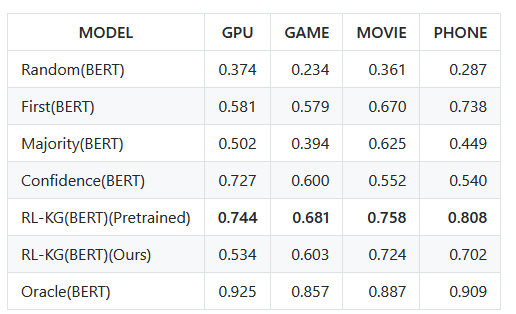

Compared to the Papers results, we got worse training accuracy within the Bert Model. This could be due to less training time. We experimented with different epochs on the model however found that the default of 2 gave the best accuracy. Another possible reason for the different results could be not training on additional data. The paper used two different datasets for the training. However, the second dataset was unavailable to us.  The Deep Q learning model was the most successful in selecting the most accurate answer than the other baseline metrics. 



# Conclusion and Future Direction

In this paper the application of both knowledge graphs, and reinforcement learning techniques are shown to be effective at tackling open attribute value extraction problems; both techniques used in conjunction showing significant improvement over the baseline measures. 

 In our literature review we found many recent papers in NLP published on both the use of knowledge graphs for entity and entity relation extraction as well as the use of deep reinforcement learning techniques for a host of NLP problems. Leading us to conclude that this is an exciting and growing area of interest in NLP with many possible applications. The authors of the paper suggest that a future direction of study might be to leverage the knowledge  graph to design the reward in the RL framework to provide weak supervision.


In the future, we would aim to implement an English version of the Datasets and knowledge graphs to test how language differences can change the effectiveness of the project. We also would like to Test how using different squad training data can change the results of fine-tuning the Bert model for our questions  








# References:

[1]: Narasimhan, Karthik & Yala, Adam & Barzilay, Regina. (2016). Improving Information Extraction by Acquiring External Evidence with Reinforcement Learning. 2355-2365. 10.18653/v1/D16-1261.

[2]: Seo, Minjoon & Kembhavi, Aniruddha & Farhadi, Ali & Hajishirzi, Hannaneh. (2016). Bidirectional Attention Flow for Machine Comprehension.

[3]: Karamanolakis, Giannis & Ma, Jun & Dong, Xin. (2020). TXtract: Taxonomy-Aware Knowledge Extraction for Thousands of Product Categories. 8489-8502. 10.18653/v1/2020.acl-main.751.

[4]:  Liu, Ye & Zhang, Sheng & Song, Rui & Feng, Suo & Xiao, Yanghua. (2020). Knowledge-guided Open Attribute Value Extraction with Reinforcement Learning. 8595-8604. 10.18653/v1/2020.emnlp-main.693. 

[5]: Annervaz, K. M., Somnath Basu Roy Chowdhury, and Ambedkar Dukkipati. “Learning beyond Datasets: Knowledge Graph Augmented Neural Networks for Natural Language Processing,” February 16, 2018. https://arxiv.org/abs/1802.05930v2.

[6]: Yu, Donghan, Chenguang Zhu, Yiming Yang, and Michael Zeng. “JAKET: Joint Pre-Training of Knowledge Graph and Language Understanding,” October 2, 2020. https://arxiv.org/abs/2010.00796v1.

[7]: Kreutzer, Julia, Stefan Riezler, and Carolin Lawrence. “Learning from Human Feedback: Challenges for Real-World Reinforcement Learning in NLP,” November 4, 2020. https://arxiv.org/abs/2011.02511v2.

